# Initial Probe into DB

In [11]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Load .env / mongo.env if present in working directory
# switch to backend dir so load_dotenv() reads ../backend/.env or mongo.env
try:
    os.chdir("../backend")
    print("Changed working directory to", os.getcwd())
except FileNotFoundError:
    print("Directory ../backend not found, keeping current working directory")
    
load_dotenv(dotenv_path=".env")
load_dotenv(dotenv_path="mongo.env")

env_names = [
    'NYT_API_KEY',
    'GOOGLE_GEMINI_API_KEY',
    'MONGO_INITDB_ROOT_USERNAME',
    'MONGO_INITDB_ROOT_PASSWORD',
    'MONGO_PORT',
    'MONGO_HOST',
    'THROTTLE_TIME',
    'MONGO_INITDB_DATABASE',
    'POLYGON_API_KEY',
    'POLYGON_API_KEY_1',
    'POLYGON_API_KEY_2',
    'POLYGON_API_KEY_3',
    'POLYGON_API_KEY_4',
    'POLYGON_API_KEY_5',
]

env = {name: os.getenv(name) for name in env_names}
print('Loaded environment variables:')
for k, v in env.items():
    if v:
        print(f'{k}: Found')
    else: 
        print(f'{k}: Missing')

# Build MongoDB client from environment (will attempt auth if username/password provided)
mongo_host = 'localhost'
mongo_port = int(env.get('MONGO_PORT') or 27017)
mongo_user = env.get('MONGO_INITDB_ROOT_USERNAME')
mongo_pass = env.get('MONGO_INITDB_ROOT_PASSWORD')
mongo_db = env.get('MONGO_INITDB_DATABASE') or 'stocks'

if mongo_user and mongo_pass:
    mongo_uri = f'mongodb://{mongo_user}:{mongo_pass}@{mongo_host}:{mongo_port}/'
else:
    mongo_uri = f'mongodb://{mongo_host}:{mongo_port}/'

print('Connecting to MongoDB...')
client = MongoClient(mongo_uri)
db = client[mongo_db]
print('Connected to MongoDB database:', mongo_db)

Changed working directory to /Users/kaituranski/Documents/Programming/Web Apps/StockSavvy/backend
Loaded environment variables:
NYT_API_KEY: Found
GOOGLE_GEMINI_API_KEY: Found
MONGO_INITDB_ROOT_USERNAME: Found
MONGO_INITDB_ROOT_PASSWORD: Found
MONGO_PORT: Found
MONGO_HOST: Found
THROTTLE_TIME: Found
MONGO_INITDB_DATABASE: Found
POLYGON_API_KEY: Found
POLYGON_API_KEY_1: Found
POLYGON_API_KEY_2: Found
POLYGON_API_KEY_3: Found
POLYGON_API_KEY_4: Found
POLYGON_API_KEY_5: Found
Connecting to MongoDB...
Connected to MongoDB database: stocksdb_v1


Loaded 100 allowed tickers from ../backend/scraper/article_instructions.json
Allowed tickers: ['AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'TSM', 'INTC', 'AMD', 'AVGO', 'QCOM', 'CSCO', 'ORCL', 'CRM', 'IBM', 'SAP', 'ADBE', 'NFLX', 'PYPL', 'SQ', 'SHOP', 'NOW', 'ZM', 'TEAM', 'SNOW', 'PLTR', 'TWLO', 'CRWD', 'OKTA', 'FTNT', 'PANW', 'ZS', 'DDOG', 'SPLK', 'MDB', 'ESTC', 'U', 'RBLX', 'ROKU', 'SE', 'SPOT', 'SNAP', 'PINS', 'COIN', 'MELI', 'NXPI', 'MCHP', 'ADI', 'LRCX', 'AMAT', 'KLAC', 'ASML', 'MRVL', 'SNPS', 'CDNS', 'ARM', 'DBX', 'BOX', 'DOCU', 'INTU', 'ADSK', 'ANSS', 'EA', 'TTWO', 'NTDOY', 'ERIC', 'NOK', 'V', 'MA', 'BABA', 'TCEHY', 'BIDU', 'JD', 'PDD', 'ASAN', 'NET', 'FSLY', 'AKAM', 'TTD', 'AI', 'STX', 'WDC', 'ON', 'EQIX', 'DLR', 'EBAY', 'VMW', 'WDAY', 'VEEV', 'HUBS', 'CFLT', 'HPE', 'HPQ', 'DELL', 'FISV', 'FIS', 'GTLB', 'HOOD']


Tickers processed: 100%|██████████| 100/100 [00:00<00:00, 301.16it/s]

/var/folders/fj/3dl8rf214jqcw2z2kdlt5b8h0000gt/T/ipykernel_28391/2582664015.py:90: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/fj/3dl8rf214jqcw2z2kdlt5b8h0000gt/T/ipykernel_28391/2582664015.py:90: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


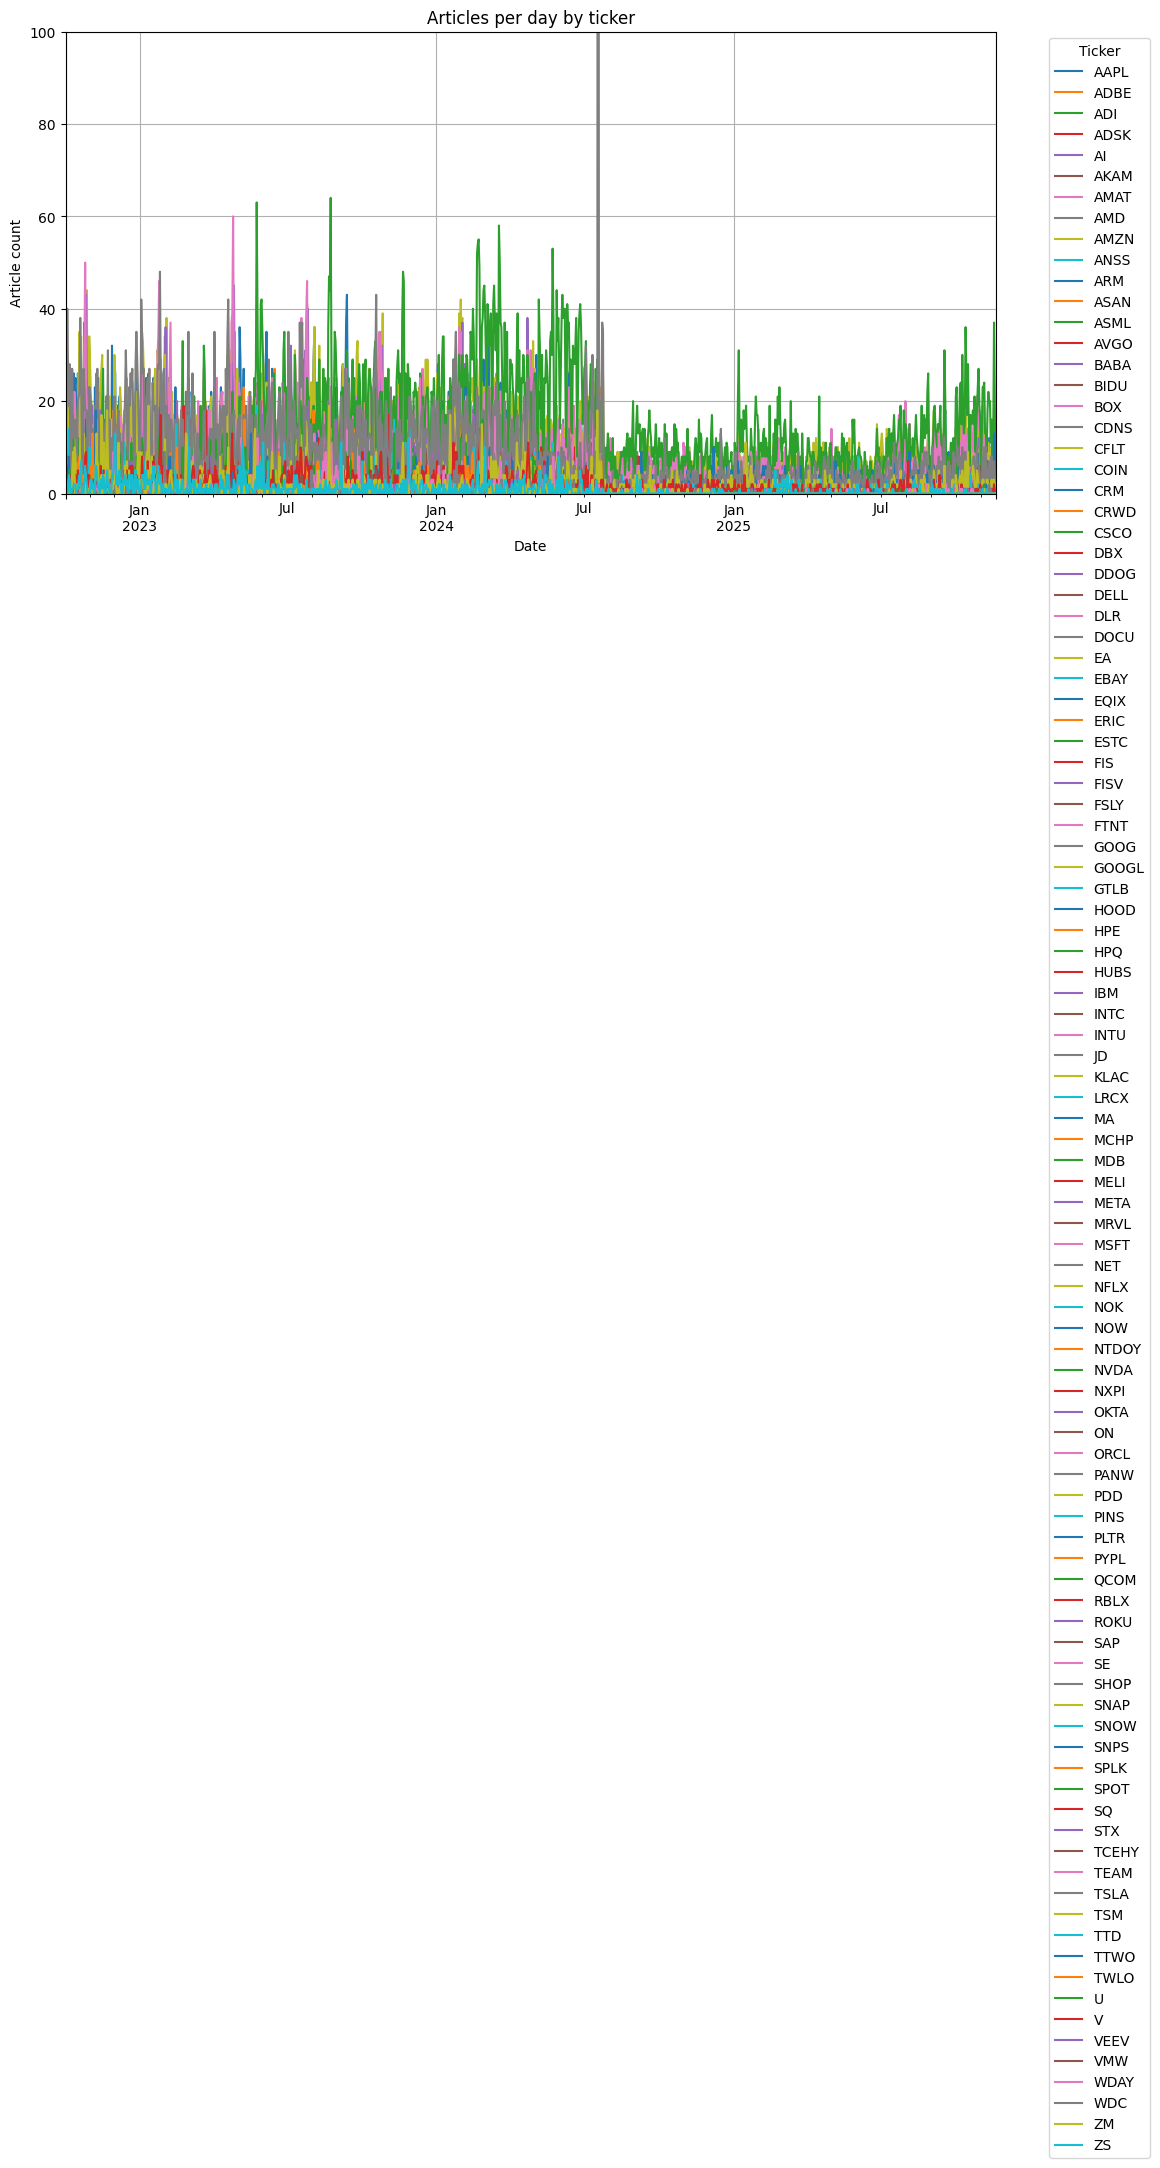

In [15]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

# Load allowed tickers from instructions JSON (if available)
instr_path = Path("../backend/scraper/article_instructions.json")
allowed_tickers = None
try:
    with instr_path.open() as f:
        instr = json.load(f)
    def extract_tickers(instr):
        if isinstance(instr, list):
            if all(isinstance(x, str) for x in instr):
                return instr
            out = []
            for item in instr:
                if isinstance(item, dict):
                    for k in ('ticker', 'symbol', 'tickers', 'symbols'):
                        v = item.get(k)
                        if isinstance(v, str):
                            out.append(v)
                            break
                        if isinstance(v, list):
                            out.extend([x for x in v if isinstance(x, str)])
                            break
            return out
        if isinstance(instr, dict):
            for k in ('tickers', 'symbols'):
                v = instr.get(k)
                if isinstance(v, list) and all(isinstance(x, str) for x in v):
                    return v
            for v in instr.values():
                if isinstance(v, list) and all(isinstance(x, str) for x in v):
                    return v
        return None
    allowed_tickers = extract_tickers(instr)
    if allowed_tickers:
        allowed_tickers = [t.upper() for t in allowed_tickers]
        print(f'Loaded {len(allowed_tickers)} allowed tickers from {instr_path}')
    else:
        print(f'No tickers found in {instr_path}; will plot all tickers')
except FileNotFoundError:
    print(f'{instr_path} not found; will plot all tickers')
except Exception as e:
    print(f'Error reading {instr_path}: {e}; will plot all tickers')

# We'll process tickers one-by-one so we can show progress with tqdm
tickers = db.ticker_news.distinct('tickers')
if allowed_tickers:
    tickers = [t for t in tickers if t and t.upper() in allowed_tickers]

print('Allowed tickers:', allowed_tickers)

all_rows = []
if not tickers:
    print('No tickers found in `ticker_news`.')
else:
    for ticker in tqdm(tickers, desc='Tickers processed'):
        pipeline = [
            {'$match': {'tickers': ticker}},
            {'$group': {
                '_id': {'day': {'$dateToString': {'format': '%Y-%m-%d', 'date': '$published_at'}}},
                'count': {'$sum': 1}
            }},
            {'$sort': {'_id.day': 1}}
        ]
        cursor = db.ticker_news.aggregate(pipeline)
        for r in cursor:
            all_rows.append({'ticker': ticker, 'day': r['_id']['day'], 'count': r['count']})

    if not all_rows:
        print('No articles found in `ticker_news`.')
    else:
        df = pd.DataFrame(all_rows)
        df['day'] = pd.to_datetime(df['day'])
        # Pivot to wide format: index=day, columns=ticker, values=count
        pivot = df.pivot_table(index='day', columns='ticker', values='count', fill_value=0)
        pivot.sort_index(inplace=True)

        # Render as a line chart (no markers)
        ax = pivot.plot(kind='line', figsize=(12, 6), linewidth=1.5)
        ax.set_title('Articles per day by ticker')
        ax.set_xlabel('Date')
        ax.set_ylabel('Article count')
        ax.grid(True)
        ax.set_ylim(0, 100)
        plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

/var/folders/fj/3dl8rf214jqcw2z2kdlt5b8h0000gt/T/ipykernel_28391/1461069757.py:86: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


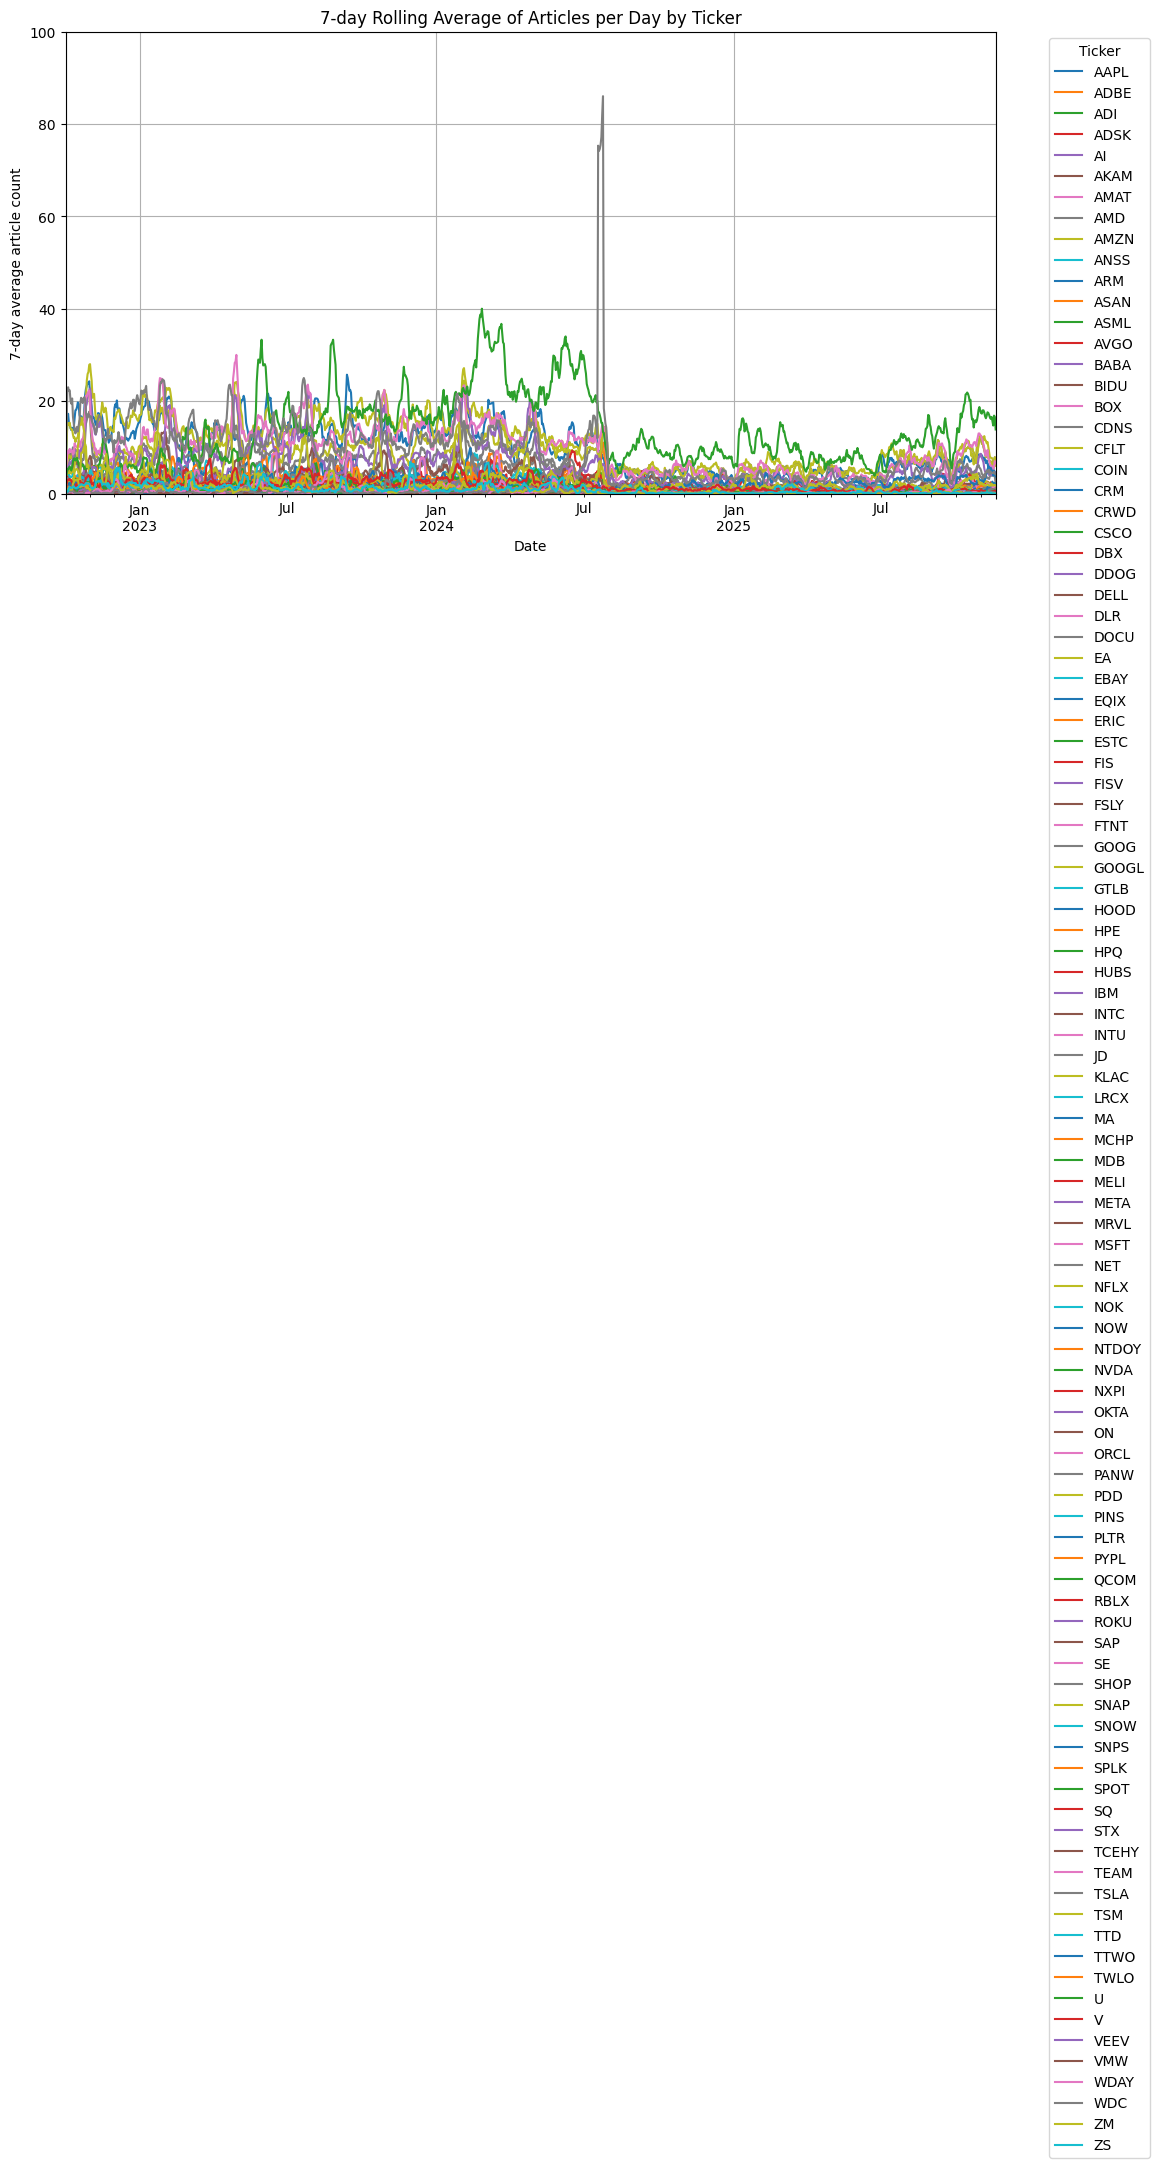

In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

# Compute a 7-day rolling average of articles per day and plot for the same tickers
# If `pivot` is not in the current kernel namespace, rebuild it (same logic as the main cell).
try:
    pivot  # see if pivot already exists
except NameError:
    instr_path = Path("../backend/scraper/article_instructions.json")
    allowed_tickers = None
    try:
        with instr_path.open() as f:
            instr = json.load(f)
        def extract_tickers(instr):
            if isinstance(instr, list):
                if all(isinstance(x, str) for x in instr):
                    return instr
                out = []
                for item in instr:
                    if isinstance(item, dict):
                        for k in ('ticker', 'symbol', 'tickers', 'symbols'):
                            v = item.get(k)
                            if isinstance(v, str):
                                out.append(v)
                                break
                            if isinstance(v, list):
                                out.extend([x for x in v if isinstance(x, str)])
                                break
                return out
            if isinstance(instr, dict):
                for k in ('tickers', 'symbols'):
                    v = instr.get(k)
                    if isinstance(v, list) and all(isinstance(x, str) for x in v):
                        return v
                for v in instr.values():
                    if isinstance(v, list) and all(isinstance(x, str) for x in v):
                        return v
            return None
        allowed_tickers = extract_tickers(instr)
        if allowed_tickers:
            allowed_tickers = [t.upper() for t in allowed_tickers]
    except Exception:
        allowed_tickers = None

    tickers = db.ticker_news.distinct('tickers')
    if allowed_tickers:
        tickers = [t for t in tickers if t and t.upper() in allowed_tickers]

    all_rows = []
    if tickers:
        for ticker in tqdm(tickers, desc='Tickers for rolling avg'):
            pipeline = [
                {'$match': {'tickers': ticker}},
                {'$group': {
                    '_id': {'day': {'$dateToString': {'format': '%Y-%m-%d', 'date': '$published_at'}}},
                    'count': {'$sum': 1}
                }},
                {'$sort': {'_id.day': 1}}
            ]
            cursor = db.ticker_news.aggregate(pipeline)
            for r in cursor:
                all_rows.append({'ticker': ticker, 'day': r['_id']['day'], 'count': r['count']})

    if not all_rows:
        raise RuntimeError('No article rows available to compute rolling average. Run the main cell first or ensure DB has data.')
    df = pd.DataFrame(all_rows)
    df['day'] = pd.to_datetime(df['day'])
    pivot = df.pivot_table(index='day', columns='ticker', values='count', fill_value=0)
    pivot.sort_index(inplace=True)

# Ensure daily frequency (fill missing days with 0) then compute 7-day rolling mean
daily = pivot.asfreq('D', fill_value=0)
rolling7 = daily.rolling(window=7, min_periods=1).mean()

# Plot the rolling average
ax = rolling7.plot(kind='line', figsize=(12, 6), linewidth=1.5)
ax.set_title('7-day Rolling Average of Articles per Day by Ticker')
ax.set_xlabel('Date')
ax.set_ylabel('7-day average article count')
ax.grid(True)
ax.set_ylim(0, 100)
plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
# Compute average articles per day per ticker and show sorted table
import json
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from IPython.display import display

# Rebuild `pivot` if necessary (same logic as other cells)
try:
    pivot
except NameError:
    instr_path = Path("../backend/scraper/article_instructions.json")
    allowed_tickers = None
    try:
        with instr_path.open() as f:
            instr = json.load(f)
        def extract_tickers(instr):
            if isinstance(instr, list):
                if all(isinstance(x, str) for x in instr):
                    return instr
                out = []
                for item in instr:
                    if isinstance(item, dict):
                        for k in ('ticker', 'symbol', 'tickers', 'symbols'):
                            v = item.get(k)
                            if isinstance(v, str):
                                out.append(v)
                                break
                            if isinstance(v, list):
                                out.extend([x for x in v if isinstance(x, str)])
                                break
                return out
            if isinstance(instr, dict):
                for k in ('tickers', 'symbols'):
                    v = instr.get(k)
                    if isinstance(v, list) and all(isinstance(x, str) for x in v):
                        return v
                for v in instr.values():
                    if isinstance(v, list) and all(isinstance(x, str) for x in v):
                        return v
            return None
        allowed_tickers = extract_tickers(instr)
        if allowed_tickers:
            allowed_tickers = [t.upper() for t in allowed_tickers]
    except Exception:
        allowed_tickers = None

    tickers = db.ticker_news.distinct('tickers')
    if allowed_tickers:
        tickers = [t for t in tickers if t and t.upper() in allowed_tickers]

    all_rows = []
    if tickers:
        for ticker in tqdm(tickers, desc='Tickers for avg'):
            pipeline = [
                {'$match': {'tickers': ticker}},
                {'$group': {
                    '_id': {'day': {'$dateToString': {'format': '%Y-%m-%d', 'date': '$published_at'}}},
                    'count': {'$sum': 1}
                }},
                {'$sort': {'_id.day': 1}}
            ]
            cursor = db.ticker_news.aggregate(pipeline)
            for r in cursor:
                all_rows.append({'ticker': ticker, 'day': r['_id']['day'], 'count': r['count']})

    if not all_rows:
        raise RuntimeError('No article rows available to compute averages. Run the main cell first or ensure DB has data.')
    df = pd.DataFrame(all_rows)
    df['day'] = pd.to_datetime(df['day'])
    pivot = df.pivot_table(index='day', columns='ticker', values='count', fill_value=0)
    pivot.sort_index(inplace=True)

# Ensure daily frequency and compute mean per ticker
daily = pivot.asfreq('D', fill_value=0)
avg_series = daily.mean().sort_values(ascending=False)
avg_df = avg_series.reset_index()
avg_df.columns = ['ticker', 'avg_articles_per_day']
avg_df['avg_articles_per_day'] = avg_df['avg_articles_per_day'].round(3)

# Display the full sorted table
display(avg_df)

# Print top 10 for quick view
print('\nTop 10 tickers by average articles per day:')
print(avg_df.head(10).to_string(index=False))

,ticker,avg_articles_per_day
0,NVDA,13.726
1,AMZN,11.447
2,AAPL,10.122
3,MSFT,9.887
4,TSLA,9.325
...,...,...
95,VMW,0.162
96,ESTC,0.149
97,FISV,0.104
98,TCEHY,0.091



Top 10 tickers by average articles per day:
ticker  avg_articles_per_day
  NVDA                13.726
  AMZN                11.447
  AAPL                10.122
  MSFT                 9.887
  TSLA                 9.325
 GOOGL                 8.630
  GOOG                 6.931
  META                 6.812
   AMD                 3.887
  INTC                 3.108
